In [1]:
import numpy as np
import time
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, random_split
import torch.optim as optim
import matplotlib.pyplot as plt
import sys, os

project_root = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))
sys.path.append(project_root)

from Resources.Model import Model_v9
from Resources.Game import *


### Initializing shared game stats
##### Only once st the start

In [2]:
# stats = torch.Tensor([0, 0, 0, 0]) # batch index, white wins, black wins, draws
# torch.save(stats, '/Users/Philip/Desktop/Projects/RL Chess/MCTS/Game Saves v9/stats')

##### Initialize Model

In [3]:
model = Model_v9()
model_saves = os.listdir('../Monte Carlo/Model Saves MC v9')
if len(model_saves) > 0:
    newest_model = max(int(i[6:-8]) for i in model_saves)
    latest_batch_index = newest_model
    model.load_state_dict(torch.load('../Monte Carlo/Model Saves MC v9/model_{}_batches'.format(newest_model)))
criterion = nn.MSELoss()

# error_hist =  []
# latest_batch_index = 0

error_hist = torch.load('./error_hist MC v9')

batches:  tensor(1, dtype=torch.int32)
batches:  tensor(2, dtype=torch.int32)
batches:  tensor(4, dtype=torch.int32)
batches:  tensor(5, dtype=torch.int32)
batches:  tensor(6, dtype=torch.int32)
batches:  tensor(7, dtype=torch.int32)
batches:  tensor(8, dtype=torch.int32)
batches:  tensor(9, dtype=torch.int32)
batches:  tensor(11, dtype=torch.int32)
batches:  tensor(12, dtype=torch.int32)
batches:  tensor(13, dtype=torch.int32)
batches:  tensor(14, dtype=torch.int32)
batches:  tensor(15, dtype=torch.int32)
batches:  tensor(16, dtype=torch.int32)
batches:  tensor(17, dtype=torch.int32)
batches:  tensor(18, dtype=torch.int32)
batches:  tensor(19, dtype=torch.int32)
batches:  tensor(20, dtype=torch.int32)


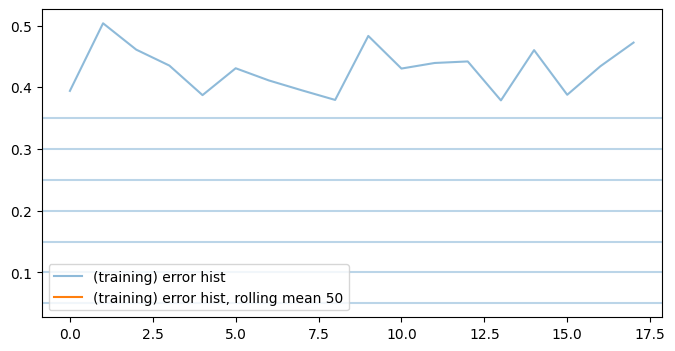

batches:  tensor(21, dtype=torch.int32)
batches:  tensor(23, dtype=torch.int32)
batches:  tensor(24, dtype=torch.int32)
batches:  tensor(26, dtype=torch.int32)
batches:  tensor(27, dtype=torch.int32)
batches:  tensor(28, dtype=torch.int32)
batches:  tensor(29, dtype=torch.int32)
batches:  tensor(30, dtype=torch.int32)


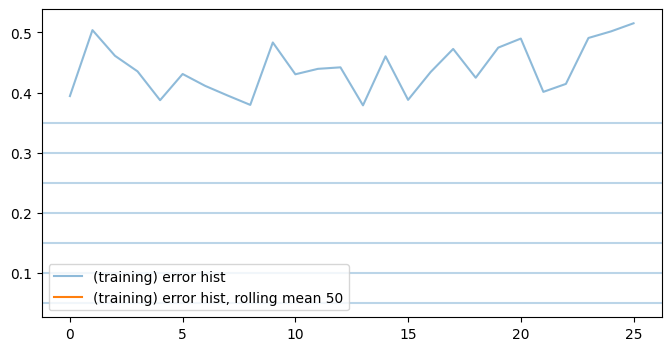

batches:  tensor(31, dtype=torch.int32)
batches:  tensor(32, dtype=torch.int32)
batches:  tensor(33, dtype=torch.int32)
batches:  tensor(34, dtype=torch.int32)
batches:  tensor(35, dtype=torch.int32)
batches:  tensor(36, dtype=torch.int32)
batches:  tensor(37, dtype=torch.int32)
batches:  tensor(38, dtype=torch.int32)
batches:  tensor(39, dtype=torch.int32)
batches:  tensor(40, dtype=torch.int32)


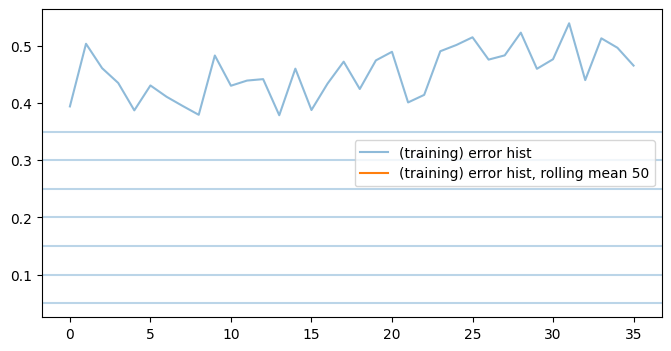

batches:  tensor(41, dtype=torch.int32)
batches:  tensor(42, dtype=torch.int32)
batches:  tensor(44, dtype=torch.int32)
batches:  tensor(45, dtype=torch.int32)
batches:  tensor(46, dtype=torch.int32)
batches:  tensor(47, dtype=torch.int32)
batches:  tensor(48, dtype=torch.int32)
batches:  tensor(49, dtype=torch.int32)
batches:  tensor(50, dtype=torch.int32)


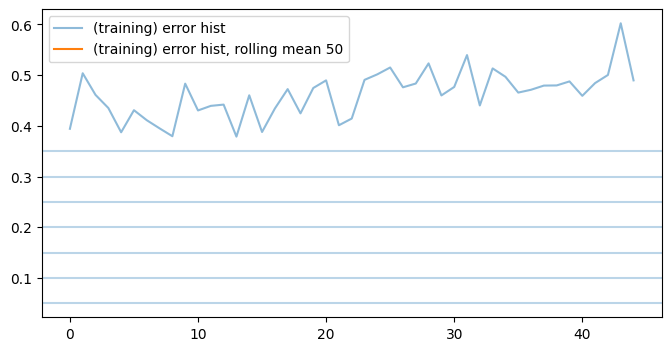

batches:  tensor(51, dtype=torch.int32)
batches:  tensor(52, dtype=torch.int32)
batches:  tensor(53, dtype=torch.int32)
batches:  tensor(54, dtype=torch.int32)
batches:  tensor(55, dtype=torch.int32)
batches:  tensor(56, dtype=torch.int32)
batches:  tensor(57, dtype=torch.int32)
batches:  tensor(58, dtype=torch.int32)
batches:  tensor(59, dtype=torch.int32)
batches:  tensor(60, dtype=torch.int32)


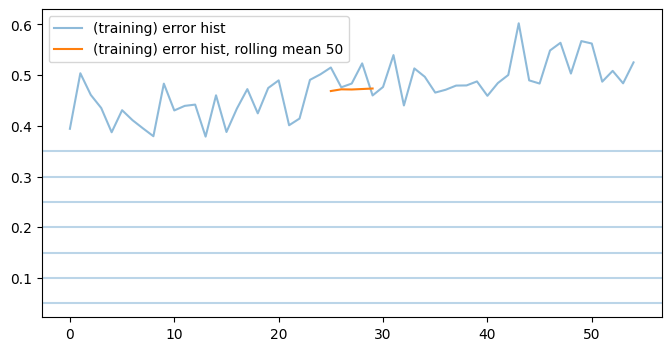

batches:  tensor(61, dtype=torch.int32)
batches:  tensor(62, dtype=torch.int32)
batches:  tensor(63, dtype=torch.int32)
batches:  tensor(64, dtype=torch.int32)
batches:  tensor(65, dtype=torch.int32)
batches:  tensor(66, dtype=torch.int32)
batches:  tensor(67, dtype=torch.int32)
batches:  tensor(68, dtype=torch.int32)
batches:  tensor(69, dtype=torch.int32)
batches:  tensor(70, dtype=torch.int32)


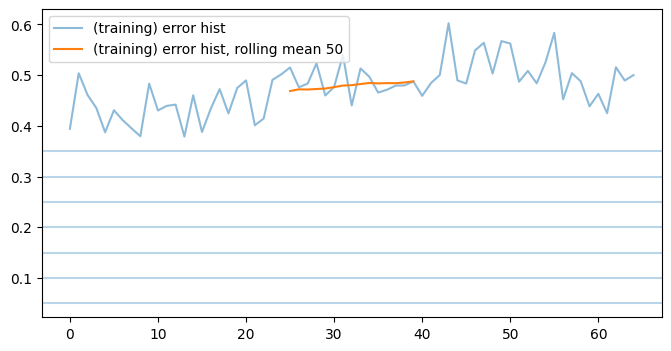

batches:  tensor(71, dtype=torch.int32)
batches:  tensor(72, dtype=torch.int32)
batches:  tensor(73, dtype=torch.int32)
batches:  tensor(74, dtype=torch.int32)
batches:  tensor(75, dtype=torch.int32)
batches:  tensor(76, dtype=torch.int32)


KeyboardInterrupt: 

In [4]:
lr0 = 1e-3
a = 250
n_batches = 100
n_replay = 10
decay_rate = 0.02 # for distribution of replay
weight_decay = 1e-7

av_window = 50 # window of averaging for error visual

while True:

    # wait for new data
    while True:
        try:
            with open('/Users/Philip/Desktop/Projects/RL Chess/MCTS/Game Saves v9/stats', 'rb') as f:
                stats = torch.load(f)
        except:
            time.sleep(0.05)
            continue
        if stats[0] - 1 > latest_batch_index:
            newest_batch = stats[0] - 1
            break
        else:
            time.sleep(0.05)

    # load all new data
    inputs = []
    labels = []
    for index in range(latest_batch_index + 1, newest_batch + 1):
        inputs.append(torch.load('/Users/Philip/Desktop/Projects/RL Chess/MCTS/Game Saves v9/inputs_{}'.format(index)))
        labels.append(torch.load('/Users/Philip/Desktop/Projects/RL Chess/MCTS/Game Saves v9/labels_{}'.format(index)))

    inputs_tens = torch.cat(inputs).float() # bool -> float
    labels_tens = torch.cat(labels)

    # get error of new data (without backprop)
    out = model(inputs_tens)
    out = out.view(out.shape[0])
    loss = criterion(out, labels_tens)
    error_hist.append(loss.item())

    # load additional older data to replay
    if latest_batch_index > 5:
        # samples from exp distribution, more recent -> more likely
        prob =  np.exp(-decay_rate * np.arange(latest_batch_index)) 
        prob = prob/sum(prob)
        num_samples = n_replay
        samples = np.random.choice(np.arange(latest_batch_index, 0, -1), size=num_samples, p=prob)
        for index in samples:
            inputs.append(torch.load('/Users/Philip/Desktop/Projects/RL Chess/MCTS/Game Saves v9/inputs_{}'.format(index)))
            labels.append(torch.load('/Users/Philip/Desktop/Projects/RL Chess/MCTS/Game Saves v9/labels_{}'.format(index)))

    inputs_tens = torch.cat(inputs).float() # bool -> float
    labels_tens = torch.cat(labels)

    # print('training batch ', newest_batch)
    t0 = time.time()

    # training step
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=lr0 * a / (a + newest_batch), weight_decay=weight_decay)

    # shuffle data and make mini batches
    indices = torch.randperm(len(inputs_tens))
    inputs_tens = inputs_tens[indices]
    labels_tens = labels_tens[indices]

    batch_size = len(inputs_tens) // n_batches

    inputs_loader = inputs_tens.split(batch_size)
    labels_loader = labels_tens.split(batch_size)

    for inputs, labels in zip(inputs_loader, labels_loader):

        out = model(inputs)
        out = out.view(out.shape[0])
        loss = criterion(out, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # print('training done ({}s)'.format(time.time() - t0))

    if newest_batch % 1 == 0 and newest_batch > 0:

        print('batches: ', newest_batch)
    
    torch.save(error_hist, './error_hist MC v9')

    if newest_batch % 10 == 0 and newest_batch > 0:


        plt.figure(figsize=(8, 4))

        plt.axhline(0.35, xmin=0, xmax=1000, alpha=0.3)
        plt.axhline(0.30, xmin=0, xmax=1000, alpha=0.3)
        plt.axhline(0.25, xmin=0, xmax=1000, alpha=0.3)
        plt.axhline(0.20, xmin=0, xmax=1000, alpha=0.3)
        plt.axhline(0.15, xmin=0, xmax=1000, alpha=0.3)
        plt.axhline(0.10, xmin=0, xmax=1000, alpha=0.3)
        plt.axhline(0.05, xmin=0, xmax=1000, alpha=0.3)

        plt.plot(error_hist, label='(training) error hist', alpha=0.5)
        plt.plot(range(av_window//2, len(error_hist) - av_window//2), [np.mean(error_hist[i:(i+av_window)]) for i in range(len(error_hist) - av_window)], label='(training) error hist, rolling mean '+str(av_window))
        plt.legend()

        plt.show()

        torch.save(model.state_dict(), './Model Saves MC v9/model_{}_batches'.format(newest_batch))

    latest_batch_index = newest_batch